<a href="https://colab.research.google.com/github/mayuresh23sawant/ds-ml/blob/master/FruitsNVeggies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai2
!pip install utils
!pip install kaggle

In [8]:
from utils import *
from fastai2.vision.all import *

In [7]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

!kaggle datasets download -d moltean/fruits

 99% 752M/760M [00:11<00:00, 79.4MB/s]
100% 760M/760M [00:11<00:00, 69.4MB/s]


In [ ]:
!unzip \*.zip  && rm *.zip

In [13]:
path=Path('/content/fruits-360')
path.ls()

(#6) [Path('/content/fruits-360/papers'),Path('/content/fruits-360/readme.md'),Path('/content/fruits-360/Test'),Path('/content/fruits-360/Training'),Path('/content/fruits-360/test-multiple_fruits'),Path('/content/fruits-360/LICENSE')]

In [10]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter = GrandparentSplitter(valid_name='Test',train_name='Training'),
                   item_tfms=Resize(224),
                   batch_tfms=[*aug_transforms(mult=1.0, size=size,min_scale=1.0),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

In [14]:
dls = get_dls(128, 128)

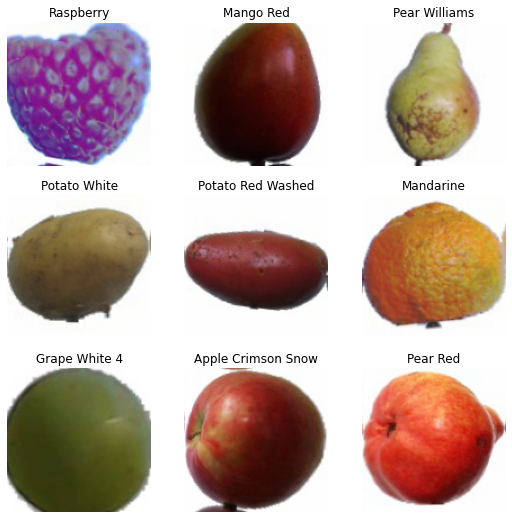

In [15]:
dls.show_batch(nrows=3,ncols=3)

In [34]:
from fastai2.callback.cutmix import *

cutmix = CutMix(1.)
learn = cnn_learner(dls, resnet50, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=[accuracy,top_k_accuracy],
                cbs=cutmix)

/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


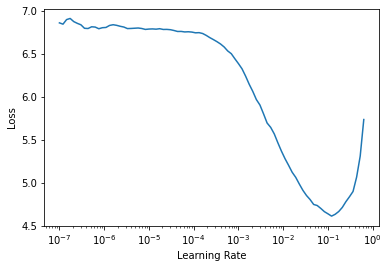

In [17]:
_,lr_steep = learn.lr_find()


In [35]:
learn.fine_tune(2,lr_steep)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.391956,1.090723,0.982370,0.998413,07:17


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.953123,0.885272,0.995725,1.000000,09:24
1,0.865218,0.834476,0.997664,0.999780,09:24


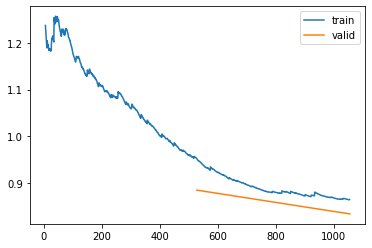

In [37]:
learn.recorder.plot_loss()

In [20]:
preds,targs = learn.tta()
print("Top 1 Accuracy: {}\nTop 5 Accuracy: {}".format(accuracy(preds, targs).item(),top_k_accuracy(preds, targs).item()))

Top 1 Accuracy: 0.9921544194221497
Top 5 Accuracy: 1.0


In [29]:
from fastai2.vision.widgets import *

path = Path()
learn_inf=learn
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [30]:
def on_click(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

In [31]:
btn_upload.observe(on_click, names=['data'])

In [32]:
display(VBox([widgets.Label('Upload an image!'), btn_upload, out_pl, lbl_pred]))

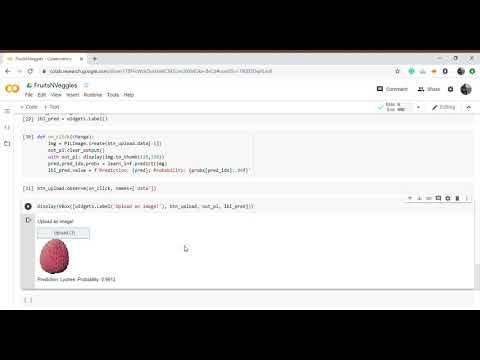

In [38]:
from IPython.display import YouTubeVideo
YouTubeVideo('X_lfxXm43M8')